In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

Using TensorFlow backend.


In [2]:
patch_size = 56
batch_size = 128
latent_dim = 128

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready/'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches  -- tensor of stacked patches    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches = []
    
    for file_patch in files_patches:
        patch = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patches.append(patch)
        
    patches = np.array(patches)
    patches = patches.astype(np.float64) / 255
    patches = np.expand_dims(patches, -1)
        
    print("patches shape:", patches.shape)
    
    return patches

In [5]:
x_train = loading_data(train_data_dir)
x_validation = loading_data(validation_data_dir)

patches shape: (64598, 56, 56, 1)
patches shape: (8075, 56, 56, 1)


In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [7]:
class Encoder(layers.Layer):
    """Maps input patches to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        
        self.conv1 = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")
        self.conv2 = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")
        self.conv3 = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(256, activation="relu")
        self.dense_mean = layers.Dense(latent_dim, name="z_mean")
        self.dense_log_var = layers.Dense(latent_dim, name="z_log_var")
        self.sampling = Sampling()
        

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))        
        return z_mean, z_log_var, z

In [8]:
class Decoder(layers.Layer):
    """Converts z, the encoded patch vector, back into the patch."""

    def __init__(self, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        
        self.dense = layers.Dense(7 * 7 * 64, activation="relu")
        self.reshape = layers.Reshape((7, 7, 64))
        self.conv1 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")
        self.conv2 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")
        self.conv3 = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")
        self.conv_output = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
        
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv_output(x)
        return x

In [9]:
class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        name="vae",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

In [10]:
vae = VariationalAutoEncoder()

In [11]:
optimiser = tf.keras.optimizers.Adam(learning_rate=1e-3)
reconstruction_loss = tf.keras.losses.BinaryCrossentropy()
loss_metric = tf.keras.metrics.Mean()

In [12]:
# train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [18]:
# def augment(image,label):
#     image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
#     image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
#     image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
#     return image,label

# augmented_train_batches = (
#     (x_train, x_train)
#     .map(augment, num_parallel_calls=AUTOTUNE)
#     .batch(batch_size)
#     .prefetch(AUTOTUNE)
# ) 


AttributeError: 'tuple' object has no attribute 'map'

In [21]:
# @tf.function
# def rotate_tf(image):
#     return image

In [23]:
# train_ds = tf.data.Dataset.from_tensor_slices(x_train)
# train_ds = train_ds.batch(512).map(rotate_tf)
# for x in train_ds:
#     X = x.numpy().reshape((-1,28,28))

In [13]:
# tf.keras.backend.set_floatx('float64')

In [98]:
x_train.shape[0] // batch_size

504

In [15]:
image_datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.2,
    width_shift_range=0.3, height_shift_range=0.3, shear_range=0.2,
    horizontal_flip=False, fill_mode="nearest")

In [30]:
epochs = 50

for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))
    
    # TODO add shuffling of the dataset here
    
    for step in range(x_train.shape[0] // batch_size):
        batch = x_train[step * batch_size: (step + 1) * batch_size]
        batch_augm = []
        for i in range(batch_size):
            patch = batch[i]
            patch_augm = image_datagen.random_transform(patch)
            batch_augm.append(patch_augm)
        batch_augm = np.array(batch_augm)      
        
#         batch_ds = tf.data.Dataset.from_tensor_slices(batch)
#         batch_augm_ds = tf.data.Dataset.from_tensor_slices(batch_augm)
        
#     for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(batch_augm)
            # Compute reconstruction loss
            loss = reconstruction_loss(batch, reconstructed)
            loss += sum(vae.losses)  # Add KLD regularization loss

        grads = tape.gradient(loss, vae.trainable_weights)
        optimiser.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step % 100 == 0:
            print("step %d: mean loss = %.4f" % (step, loss_metric.result()))

Start of epoch 0
step 0: mean loss = 0.6437
step 100: mean loss = 0.6433
step 200: mean loss = 0.6415
step 300: mean loss = 0.6392
step 400: mean loss = 0.6373
step 500: mean loss = 0.6354
Start of epoch 1
step 0: mean loss = 0.6353
step 100: mean loss = 0.6346
step 200: mean loss = 0.6331
step 300: mean loss = 0.6313
step 400: mean loss = 0.6302
step 500: mean loss = 0.6291
Start of epoch 2
step 0: mean loss = 0.6290
step 100: mean loss = 0.6288
step 200: mean loss = 0.6279
step 300: mean loss = 0.6268
step 400: mean loss = 0.6261
step 500: mean loss = 0.6254
Start of epoch 3
step 0: mean loss = 0.6254
step 100: mean loss = 0.6253
step 200: mean loss = 0.6248
step 300: mean loss = 0.6240
step 400: mean loss = 0.6235
step 500: mean loss = 0.6230
Start of epoch 4
step 0: mean loss = 0.6230
step 100: mean loss = 0.6230
step 200: mean loss = 0.6226
step 300: mean loss = 0.6220
step 400: mean loss = 0.6217
step 500: mean loss = 0.6213
Start of epoch 5
step 0: mean loss = 0.6213
step 100: m

step 100: mean loss = 0.6097
step 200: mean loss = 0.6097
step 300: mean loss = 0.6097
step 400: mean loss = 0.6096
step 500: mean loss = 0.6096
Start of epoch 44
step 0: mean loss = 0.6096
step 100: mean loss = 0.6096
step 200: mean loss = 0.6096
step 300: mean loss = 0.6096
step 400: mean loss = 0.6096
step 500: mean loss = 0.6095
Start of epoch 45
step 0: mean loss = 0.6095
step 100: mean loss = 0.6096
step 200: mean loss = 0.6095
step 300: mean loss = 0.6095
step 400: mean loss = 0.6095
step 500: mean loss = 0.6094
Start of epoch 46
step 0: mean loss = 0.6094
step 100: mean loss = 0.6095
step 200: mean loss = 0.6095
step 300: mean loss = 0.6094
step 400: mean loss = 0.6094
step 500: mean loss = 0.6094
Start of epoch 47
step 0: mean loss = 0.6094
step 100: mean loss = 0.6094
step 200: mean loss = 0.6094
step 300: mean loss = 0.6093
step 400: mean loss = 0.6093
step 500: mean loss = 0.6093
Start of epoch 48
step 0: mean loss = 0.6093
step 100: mean loss = 0.6093
step 200: mean loss =

In [13]:
epochs = 50

for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)
            # Compute reconstruction loss
            loss = reconstruction_loss(x_batch_train, reconstructed)
            loss += sum(vae.losses)  # Add KLD regularization loss

        grads = tape.gradient(loss, vae.trainable_weights)
        optimiser.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step % 100 == 0:
            print("step %d: mean loss = %.4f" % (step, loss_metric.result()))

Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

step 0: mean loss = 0.6952
step 100: mean loss = 0.6722
step 200: mean loss = 0.6567


KeyboardInterrupt: 

In [27]:
for step, x_batch_train in enumerate(train_dataset):
    print(x_batch_train.shape)

(128, 56, 56, 1)
(128, 56, 56, 1)
(128, 56, 56, 1)
(120, 56, 56, 1)


In [33]:
def augment(image):
#     image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize_with_crop_or_pad(image, 62, 62) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size=[56, 56, 1]) # Random crop back to 28x28
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

    return image

In [34]:
augment(x_batch_train[0])

<tf.Tensor: shape=(56, 56, 1), dtype=float64, numpy=
array([[[0.41680586],
        [0.41680586],
        [0.41680586],
        ...,
        [0.41680586],
        [0.41680586],
        [0.41680586]],

       [[0.41680586],
        [0.41680586],
        [0.41680586],
        ...,
        [0.41680586],
        [0.41680586],
        [0.41680586]],

       [[0.41680586],
        [0.41680586],
        [0.41680586],
        ...,
        [0.41680586],
        [0.41680586],
        [0.41680586]],

       ...,

       [[0.76974702],
        [1.05602157],
        [0.75798237],
        ...,
        [0.41680586],
        [0.41680586],
        [0.41680586]],

       [[0.76582551],
        [0.67170787],
        [0.67955101],
        ...,
        [0.41680586],
        [0.41680586],
        [0.41680586]],

       [[0.94621766],
        [1.06386471],
        [0.66386467],
        ...,
        [0.41680586],
        [0.41680586],
        [0.41680586]]])>

In [35]:
temp = np.array(x_batch_train[0])

In [36]:
temp.shape

(56, 56, 1)

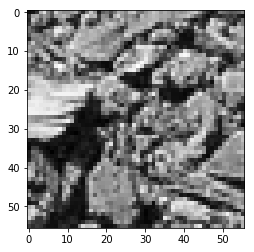

In [37]:
plt.imshow(temp[:,:,0], cmap='gray')

In [38]:
temp2 = np.array(augment(x_batch_train[0]))

In [39]:
temp2.shape

(56, 56, 1)

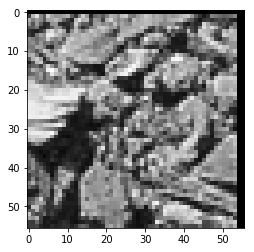

In [40]:
plt.imshow(temp2[:,:,0], cmap='gray')

In [42]:
image_datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.2,
    width_shift_range=0.3, height_shift_range=0.3, shear_range=0.2,
    horizontal_flip=False, fill_mode="nearest")

In [45]:
image_datagen.get_random_transform(img_shape=(56,56,1))

dict

In [100]:
temp.shape

(56, 56, 1)

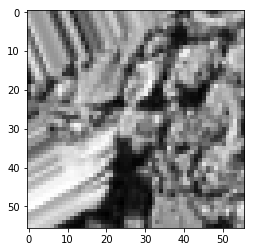

In [54]:
plt.imshow(image_datagen.random_transform(temp)[:,:,0], cmap='gray')

In [59]:
temp3 = np.ndarray(x_batch_train.shape)

In [60]:
temp3.shape

(128, 56, 56, 1)

In [63]:
def my_func(patch):
    print(patch.shape)
    h = patch.shape[0]
    w = patch.shape[1]
    c = patch.shape[2]
    return h*w*c

In [65]:
np.apply_along_axis(my_func, 1, temp3)

(56,)


IndexError: tuple index out of range

In [66]:
for patch in x_batch_train:
    print(patch)

tf.Tensor(
[[[0.07843137]
  [0.10588235]
  [0.21960784]
  ...
  [0.37254902]
  [0.40784314]
  [0.48235294]]

 [[0.23529412]
  [0.59607843]
  [0.63137255]
  ...
  [0.29019608]
  [0.15294118]
  [0.11764706]]

 [[0.18823529]
  [0.70980392]
  [0.53333333]
  ...
  [0.19215686]
  [0.23137255]
  [0.42745098]]

 ...

 [[0.76862745]
  [0.55294118]
  [0.22745098]
  ...
  [0.64705882]
  [0.68627451]
  [0.74509804]]

 [[0.37254902]
  [0.25882353]
  [0.22352941]
  ...
  [0.59607843]
  [0.47058824]
  [0.64705882]]

 [[0.2627451 ]
  [0.19215686]
  [0.24705882]
  ...
  [0.36470588]
  [0.21960784]
  [0.65098039]]], shape=(56, 56, 1), dtype=float64)
tf.Tensor(
[[[0.10196078]
  [0.10196078]
  [0.10196078]
  ...
  [0.08627451]
  [0.09019608]
  [0.08627451]]

 [[0.10588235]
  [0.10196078]
  [0.09803922]
  ...
  [0.08627451]
  [0.09411765]
  [0.10588235]]

 [[0.10588235]
  [0.10980392]
  [0.10196078]
  ...
  [0.09019608]
  [0.09019608]
  [0.10196078]]

 ...

 [[0.10588235]
  [0.10980392]
  [0.10196078]
  ..

In [85]:
import numpy as np
a = np.arange(9*5).reshape((5,3,3))

In [86]:
a

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]],

       [[27, 28, 29],
        [30, 31, 32],
        [33, 34, 35]],

       [[36, 37, 38],
        [39, 40, 41],
        [42, 43, 44]]])

In [87]:
a = a.reshape((5,9))

In [88]:
np.apply_along_axis(np.random.shuffle,0,a) 

array([None, None, None, None, None, None, None, None, None], dtype=object)

In [94]:
import numpy as np
a = np.arange(45).reshape((5,9))       
# shuffle along axis 1     
np.apply_along_axis(np.random.shuffle,1,a) 
# shuffle along axis 0
# np.random.shuffle(a)
print(a)

[[ 5  1  2  3  4  6  0  7  8]
 [12 11 17 10 15  9 13 14 16]
 [20 21 25 18 26 19 23 24 22]
 [32 28 33 35 31 34 29 27 30]
 [41 44 43 38 40 37 39 42 36]]


In [95]:
a.reshape((5,3,3))

array([[[ 5,  1,  2],
        [ 3,  4,  6],
        [ 0,  7,  8]],

       [[12, 11, 17],
        [10, 15,  9],
        [13, 14, 16]],

       [[20, 21, 25],
        [18, 26, 19],
        [23, 24, 22]],

       [[32, 28, 33],
        [35, 31, 34],
        [29, 27, 30]],

       [[41, 44, 43],
        [38, 40, 37],
        [39, 42, 36]]])